In [1]:
from cpr_gym import protocols, wrappers
import itertools
import gym
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

In [2]:
protocol_dict = dict(
    nakamoto=protocols.nakamoto(),
    tailstorm8discount=protocols.tailstorm(k=8, reward="discount"),
)


def sparse(n_pow=None, protocol=None, **kwargs):
    env = gym.make(
        "cpr_gym:core-v0", proto=protocol_dict[protocol], **kwargs, max_steps=n_pow
    )
    env = wrappers.SparseRewardPerBlockWrapper(env)
    return env


def dense(n_pow=None, protocol=None, **kwargs):
    env = gym.make("cpr_gym:core-v0", proto=protocol_dict[protocol], **kwargs)
    env = wrappers.DenseRewardPerBlockWrapper(env, n_pow=n_pow)
    return env


env_dict = dict(sparse=sparse, dense=dense)


def run_episode(env, policy=None):
    p = lambda obs: env.policy(obs, policy)
    obs = env.reset()
    acc = 0
    done = False
    while not done:
        obs, reward, done, info = env.step(p(obs))
        acc += reward
    return acc


def measure(env="sparse", n_episodes=1, policy="honest", **kwargs):
    env = env_dict[env](**kwargs)
    rewards = []
    for i in range(n_episodes):
        try:
            rewards.append(run_episode(env, policy=policy))
        except ValueError as e:
            warnings.warn(str(e))
            print(kwargs)
            print(f"policy: {policy}")
            print(e)
    return np.mean(rewards)


alpha = np.arange(0.1, 1.05, 0.1)
n_pow = [8, 16, 32, 64, 128]

dfs = []
for protocol in protocol_dict.keys():
    env = env_dict["sparse"](n_pow=128, protocol=protocol)
    df = pd.DataFrame(
        itertools.product([protocol], alpha, n_pow, env_dict.keys(), env.policies()),
        columns=["protocol", "alpha", "n_pow", "env", "policy"],
    )

    df["reward"] = df.apply(
        lambda x: measure(**x, n_episodes=10),
        axis=1,
    )
    dfs.append(df)
d = pd.concat(dfs, ignore_index=True)
d

/home/patrik/devel/cpr/python/gym/cpr_gym/wrappers.py:104: UserWarning: DenseRewardPerBlockWrapper observed less pows than expected
  warnings.warn("DenseRewardPerBlockWrapper observed less pows than expected")
/home/patrik/devel/cpr/python/gym/cpr_gym/wrappers.py:104: UserWarning: DenseRewardPerBlockWrapper observed less pows than expected
  warnings.warn("DenseRewardPerBlockWrapper observed less pows than expected")


,protocol,alpha,n_pow,env,policy,reward
0,nakamoto,0.1,8,sparse,sapirshtein-2016-sm1,0.061905
1,nakamoto,0.1,8,sparse,eyal-sirer-2014,0.014286
2,nakamoto,0.1,8,sparse,simple,0.036667
3,nakamoto,0.1,8,sparse,honest,0.137500
4,nakamoto,0.1,8,dense,sapirshtein-2016-sm1,0.062500
...,...,...,...,...,...,...
795,tailstorm8discount,1.0,128,sparse,honest,1.000000
796,tailstorm8discount,1.0,128,dense,override-catchup,0.000000
797,tailstorm8discount,1.0,128,dense,override-block,0.000000
798,tailstorm8discount,1.0,128,dense,release-block,1.000000


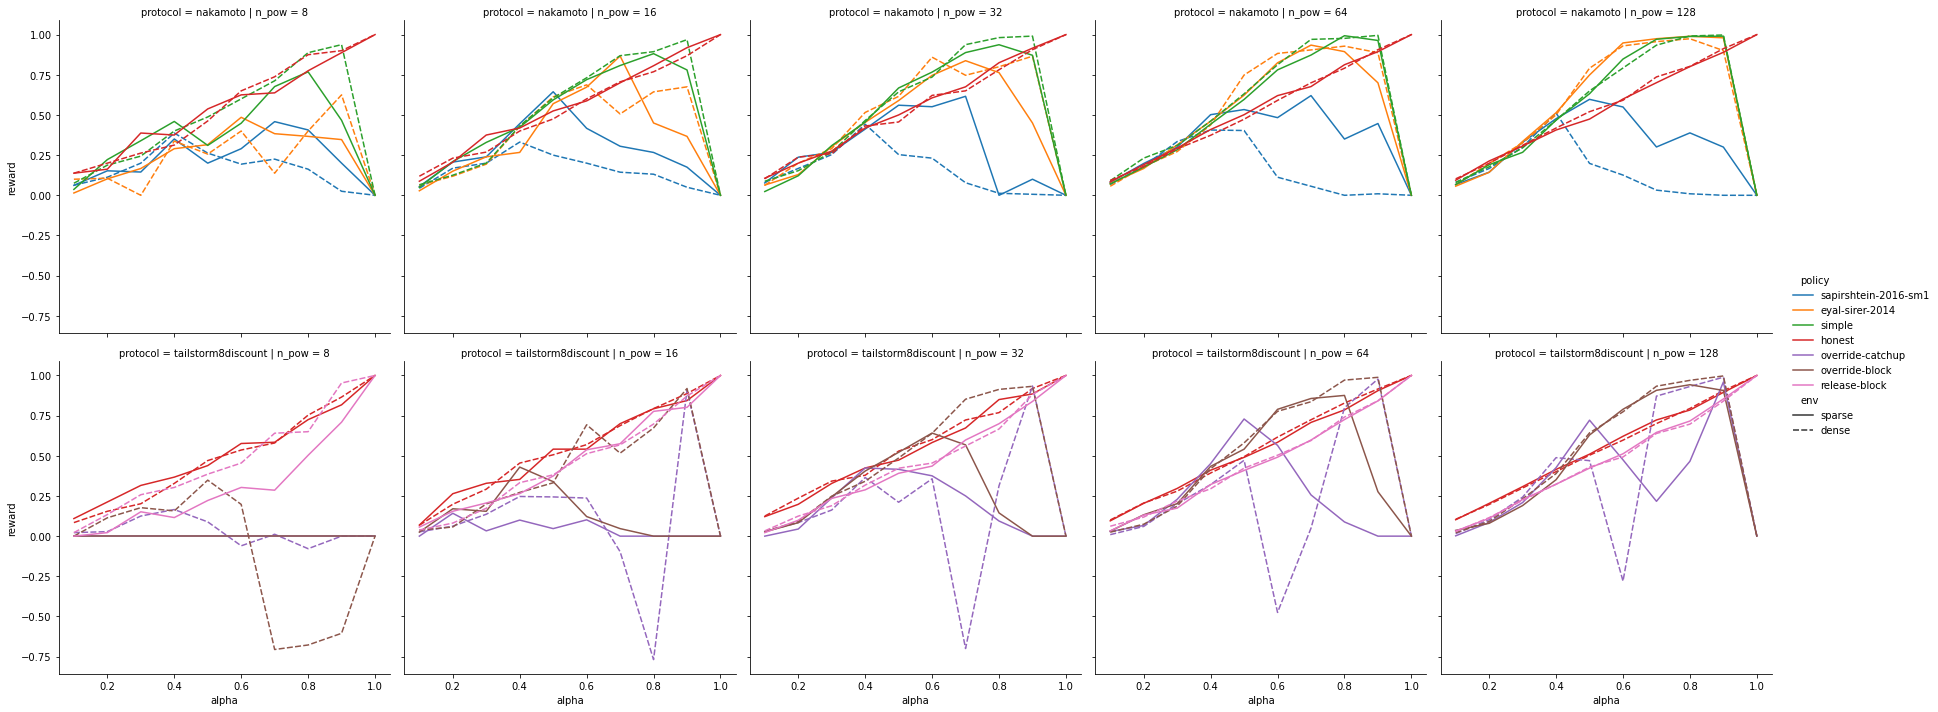

In [3]:
sns.relplot(
    data=d,
    kind="line",
    x="alpha",
    y="reward",
    hue="policy",
    style="env",
    col="n_pow",
    row="protocol",
)

Negative rewards? Needs investigation!